In [1]:
import os

# Set backend env to torch
os.environ["KERAS_BACKEND"] = "torch"

import torch
import torch.nn as nn
import torch.optim as optim
from keras_core import layers
from keras_core.layers import Conv2D, UpSampling2D, BatchNormalization, Input, Add, MaxPool2D, Activation, Concatenate,MaxPooling2D,Conv2DTranspose,Reshape,Multiply
from keras_core import Model
import keras_core as keras
import numpy as np
from tqdm import tqdm
import albumentations as A

Using PyTorch backend.


In [2]:
import json
import glob
from joblib import Parallel, delayed

In [3]:
import cv2
import math
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
new_size = (224,224)


In [5]:
def csv_parse(csv_path,img_root):
    labels_p = pd.read_csv(csv_path,names = ["class","x","y","name","w","h"]) 
    images_p = sorted(glob.glob(os.path.join(img_root+"*.jpg"))) 
    unique_names = labels_p["name"].unique()
    labels_p.index += 1 
    coords = []
    images = []
    path = img_root
    for i in unique_names:
        coords_temp = []
        mask = labels_p[labels_p["name"] == i]
        mask_len = len(mask)
        for j in range(mask_len):
            x = int(mask.iloc[j]["x"])
            y = int(mask.iloc[j]["y"])
            w = int(mask.iloc[j]["w"])
            h = int(mask.iloc[j]["h"])
            scale_x = new_size[0] / w
            scale_y = new_size[1] / h
            x = int(x * scale_x)
            y = int(y * scale_y)
            if x >= new_size[0]: x = new_size[0] -1;
            if y >= new_size[0]: y = new_size[0] -1;
            coords_temp.append([x,y])
        coords.append(coords_temp)
        image = cv2.imread(os.path.join(path,i),0)
        image = cv2.resize(image,new_size) / 255.
        images.append(image)
    return coords,images
    

In [6]:
kare_csv = "/home/rivian/Desktop/Datasets/kare.csv"
kare_path = "/home/rivian/Desktop/Datasets/kareplakalar"
kare_coords,kare_images = csv_parse(kare_csv,kare_path)

In [7]:
len(kare_coords) == len(kare_images)

True

In [8]:
yatay_csv = "/home/rivian/Desktop/Datasets/yatay.csv"
yatay_path = "/home/rivian/Desktop/Datasets/yatay_crop"
yatay_coords,yatay_images = csv_parse(yatay_csv,yatay_path)

In [9]:
len(yatay_coords) == len(yatay_images)

True

In [10]:
labels = sorted(glob.glob("/home/rivian/Desktop/Datasets/keypoint_plates/images/*.json"))
images = sorted(glob.glob("/home/rivian/Desktop/Datasets/keypoint_plates/images/*.jpg"))

In [11]:
def parse_json(labels,images):
    keypoints = []
    images_ = []
    for (r,i) in zip(images,labels):
        with open(i,"r") as f:
            shapes = json.load(f)["shapes"]
            pts = []
            if len(shapes) < 4: continue
            image = cv2.imread(r,0)
            resized_image = cv2.resize(image, new_size) / 255.
            images_.append(resized_image)
            scale_x = new_size[0] / image.shape[1]
            scale_y = new_size[1] / image.shape[0]
            for k in range(len(shapes)):
                points = shapes[k]["points"][0]
                points[0] = int(points[0] * scale_x)
                points[1]= int(points[1] * scale_y)
                if points[0] >= new_size[0] : points[0] = new_size[0] -1;
                if points[1] >= new_size[0] : points[1] = new_size[0] -1;
                pts.append(points)
        keypoints.append(pts)
    return keypoints,images_
    

In [12]:
keypoints,images = parse_json(labels,images)

In [13]:
len(images) == len(keypoints)

True

In [14]:
derpet_csv = "/home/rivian/Desktop/Datasets/derpet_heatmap.csv"
derpet_path = "/home/rivian/Desktop/Datasets/derpet_heatmap_data"
derpet_coords,derpet_images = csv_parse(derpet_csv,derpet_path)

In [15]:
keypoints[0]

[[27, 39], [198, 46], [191, 189], [18, 178]]

In [16]:
images[0].shape

(224, 224)

In [17]:
images = kare_images + yatay_images + images + derpet_images
keypoints = kare_coords + yatay_coords + keypoints + derpet_coords

In [18]:
np.array(images).shape

(645, 224, 224)

In [19]:
np.array(keypoints).shape

(645, 4, 2)

In [20]:
transform = A.Compose([
    A.RandomBrightnessContrast(p=0.5),
    A.HorizontalFlip(p=0.4),
    A.RandomRotate90(p=0.4),
    A.Perspective(p=0.3),
    A.Rotate(limit=30, p=0.3),
    A.PixelDropout(p=0.3),
    A.ShiftScaleRotate(p=0.5),
    A.VerticalFlip(p=0.4)
], keypoint_params=A.KeypointParams(format='xy'))

In [21]:
transform_pixelwise = A.Compose([
A.CoarseDropout(p=0.5)
],keypoint_params=A.KeypointParams(format='xy'))

In [22]:
transformed = transform(image=images[0].astype(np.float32), keypoints=keypoints[0])
transformed_image = transformed['image']
transformed_keypoints = transformed['keypoints']

In [23]:
np.array([transformed_keypoints]).shape

(1, 4, 2)

In [24]:
images_transformed = []
keypoints_transformed = []
for i,k in tqdm(zip(images,keypoints)):
    if (type(i) == str): continue;
    transformed = transform(image=i.astype(np.float32), keypoints=k)
    transformed_image = transformed['image']
    transformed_keypoints = transformed['keypoints']
    transformed_keypoints = [[transformed_keypoints[k][0],transformed_keypoints[k][1]] for k in range(0,len(transformed_keypoints))]
    if len(transformed_keypoints) < 4: 
        transformed = transform_pixelwise(image=i.astype(np.float32), keypoints=k)
        transformed_image = transformed['image']
        transformed_keypoints = transformed['keypoints']
        transformed_keypoints = [[transformed_keypoints[k][0],transformed_keypoints[k][1]] for k in range(0,len(transformed_keypoints))]
        if len(transformed_keypoints) == 4:
            keypoints_transformed.append(transformed_keypoints)
            images_transformed.append(transformed_image)
            continue
        if len(transformed_keypoints) < 4:
            keypoints_transformed.append(k)
            images_transformed.append(i)
            
            continue
    images_transformed.append(transformed_image)
    keypoints_transformed.append(transformed_keypoints)
    

645it [00:00, 1219.62it/s]


In [25]:
for i in keypoints_transformed:
    if len(i) < 4:
        print(i)

In [26]:
keypoints_transformed[0]

[[49, 177], [165, 185], [173, 47], [53, 34]]

In [27]:
images = images_transformed
keypoints = keypoints_transformed

In [28]:
#Function to create heatmaps by convoluting a 2D gaussian kernel over a (x,y) keypoint.
def gaussian(xL, yL, H, W, sigma=5):

    channel = [math.exp(-((c - xL) ** 2 + (r - yL) ** 2) / (2 * sigma ** 2)) for r in range(H) for c in range(W)]
    channel = np.array(channel, dtype=np.float32)
    channel = np.reshape(channel, newshape=(H, W))

    return channel

In [29]:
# heatmaps_label = []
# for i in tqdm(keypoints):
#     heatmaps = []
#     for j in i:
#         x = int(j[0])
#         y = int(j[1])
#         heatmap = gaussian(x, y, 224, 224)
#         heatmaps.append(heatmap)
#     heatmaps_label.append(heatmaps)

In [30]:

def generate_heatmaps(keypoints):
    heatmaps = []
    for j in keypoints:
        x = int(j[0])
        y = int(j[1])
        heatmap = gaussian(x, y, new_size[0], new_size[1])
        heatmaps.append(heatmap)
    return heatmaps

# Example keypoints list
#keypoints_list = [...]  # Replace with your actual list of keypoints

# Parallelize the loop
num_cores = 4  # Set the number of CPU cores to use


In [31]:
# images_ = np.array(images)
# images_ = images_.reshape(-1,224,224,1)
# heatmaps = np.array(heatmaps_label)
# heatmaps = np.transpose(heatmaps,(0,2,3,1))

In [32]:
if (os.path.isfile("images_.npy") == False):
    heatmaps_label = Parallel(n_jobs=num_cores)(
    delayed(generate_heatmaps)(i) for i in tqdm(keypoints)
    )
    images_ = np.array(images)
    images_ = images_.reshape(-1,new_size[0],new_size[1],1)
    heatmaps = np.array(heatmaps_label)
    heatmaps = np.transpose(heatmaps,(0,2,3,1))
    np.save("images_.npy",images_)
    np.save("heatmaps.npy",heatmaps)
else:
    heatmaps = np.load("heatmaps.npy")
    images_ = np.load("images_.npy")
    print("Loaded Data")
    
    

100%|█████████████████████████████████████████| 645/645 [00:18<00:00, 35.51it/s]


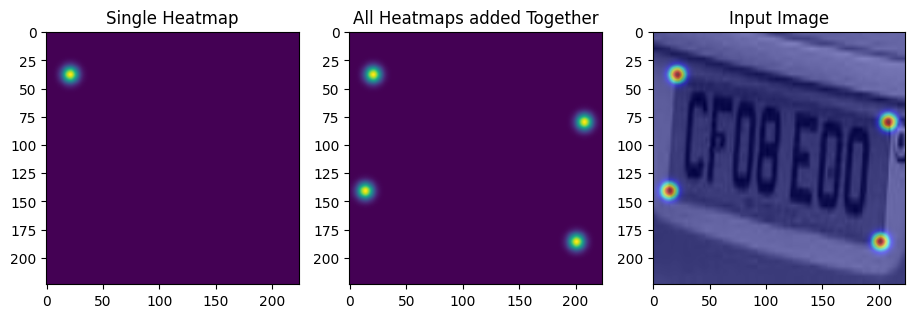

In [33]:
#heatmaps = np.array(heatmaps_label)
rint = np.random.randint(0,len(images_))
plt.figure(figsize=(15,15))

plt.subplot(1,4,1)
plt.imshow(heatmaps[rint][:,:,0])
plt.title("Single Heatmap")

plt.subplot(1,4,2)
plt.imshow(heatmaps[rint].sum(axis=2))
#plt.imshow(heatmaps.sum(axis=0))
plt.title("All Heatmaps added Together")

plt.subplot(1,4,3)
plt.imshow(images_[rint] * 255, cmap='gray')
plt.imshow(heatmaps[rint].sum(axis=2),cmap="jet",alpha=0.5)
plt.title("Input Image");

In [34]:
def conv_block(x, nconvs, n_filters, block_name, wd=None):
    for i in range(nconvs):
        x = Conv2D(n_filters, kernel_size=(3, 3), strides=1, padding='same', activation='relu',
                   kernel_regularizer=wd, name=block_name + "_conv" + str(i + 1))(x)

    x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', name=block_name + "_pool")(x)
    #x = Conv2D(n_filters, kernel_size=(3, 3), strides=2,padding='same', activation='relu',
                   #kernel_regularizer=wd, name=block_name + "_pool" + str(i + 1))(x)
    return x


def FCN8(input_shape):
    input = Input(shape=input_shape, name="Input")

    # Block 1
    x = conv_block(input, nconvs=2, n_filters=64, block_name="block1")

    # Block 2
    x = conv_block(x, nconvs=2, n_filters=128, block_name="block2")

    # Block 3
    pool3 = conv_block(x, nconvs=3, n_filters=256, block_name="block3")

    # Block 4
    pool4 = conv_block(pool3, nconvs=3, n_filters=512, block_name="block4")

    # Block 5
    x = conv_block(pool4, nconvs=3, n_filters=512, block_name="block5")

    # convolution 6
    x = Conv2D(4096, kernel_size=(1, 1), strides=1, padding="same", activation="relu", name="conv6")(x)

    # convolution 7
    x = Conv2D(15, kernel_size=(1, 1), strides=1, padding="same", activation="relu", name="conv7")(x)

    # upsampling
    preds_pool3 = Conv2D(15, kernel_size=(1, 1), strides=1, padding="same", name="preds_pool3")(pool3)
    preds_pool4 = Conv2D(15, kernel_size=(1, 1), strides=1, padding="same", name="preds_pool4")(pool4)
    up_pool4 = Conv2DTranspose(filters=15, kernel_size=2, strides=2, activation="relu", name="ConvT_pool4")(preds_pool4)
    up_conv7 = Conv2DTranspose(filters=15, kernel_size=4, strides=4, activation="relu", name="ConvT_conv7")(x)

    fusion = Add()([preds_pool3, up_pool4, up_conv7])

    output = Conv2DTranspose(filters=15, kernel_size=8, strides=8, activation='relu', name="convT_fusion")(fusion)
    output = Conv2D(4, kernel_size=(1, 1), strides=1, padding="same", activation="linear", name="output")(output)
    #output = Reshape(target_shape=(224*224*4, 1))(output)

    model = Model(inputs=input, outputs=output, name="FCN8")

    return model


model = FCN8(input_shape=(new_size[0], new_size[1], 1))

print(model.summary())

Model: "FCN8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)  │ (None, 224, 224,  │       0 │ -                    │
│                     │ 1)                │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block1_conv1        │ (None, 224, 224,  │     640 │ Input[0][0]          │
│ (Conv2D)            │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block1_conv2        │ (None, 224, 224,  │  36,928 │ block1_conv1[0][0]   │
│ (Conv2D)            │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block1_pool         │ (None, 112, 112,  │       0 │ block1_conv2[0][0]   │
│ (MaxPooling2D)      │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block2_conv1        │ (None, 112, 112,  │  73,856 │ block1_pool[0][0]    │
│ (Conv2D)            │ 128)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block2_conv2        │ (None, 112, 112,  │ 147,584 │ block2_conv1[0][0]   │
│ (Conv2D)            │ 128)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block2_pool         │ (None, 56, 56,    │       0 │ block2_conv2[0][0]   │
│ (MaxPooling2D)      │ 128)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block3_conv1        │ (None, 56, 56,    │ 295,168 │ block2_pool[0][0]    │
│ (Conv2D)            │ 256)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block3_conv2        │ (None, 56, 56,    │ 590,080 │ block3_conv1[0][0]   │
│ (Conv2D)            │ 256)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block3_conv3        │ (None, 56, 56,    │ 590,080 │ block3_conv2[0][0]   │
│ (Conv2D)            │ 256)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block3_pool         │ (None, 28, 28,    │       0 │ block3_conv3[0][0]   │
│ (MaxPooling2D)      │ 256)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block4_conv1        │ (None, 28, 28,    │ 1,180,… │ block3_pool[0][0]    │
│ (Conv2D)            │ 512)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block4_conv2        │ (None, 28, 28,    │ 2,359,… │ block4_conv1[0][0]   │
│ (Conv2D)            │ 512)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block4_conv3        │ (None, 28, 28,    │ 2,359,… │ block4_conv2[0][0]   │
│ (Conv2D)            │ 512)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block4_pool         │ (None, 14, 14,    │       0 │ block4_conv3[0][0]   │
│ (MaxPooling2D)      │ 512)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block5_conv1        │ (None, 14, 14,    │ 2,359,… │ block4_pool[0][0]    │
│ (Conv2D)            │ 512)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ block5_conv2        │ (None, 14, 14,    │ 2,359,… │ block5_conv1[0][0] 

 Total params: 16,906,798 (515.95 MB)

 Trainable params: 16,906,798 (515.95 MB)

 Non-trainable params: 0 (0.00 B)

None


In [35]:
from keras_core.metrics import MeanIoU

In [36]:
num_classes = 4
iou_metric = MeanIoU(num_classes=num_classes)

In [37]:
def jaccard_metric(y_true, y_pred):
    intersection = keras.ops.sum(keras.ops.absolute(torch.tensor(y_true).cuda() * y_pred), axis=-1)
    union = keras.ops.sum(keras.ops.absolute(y_true) + keras.ops.absolute(y_pred), axis=-1) - intersection
    jaccard = (intersection + 1e-7) / (union + 1e-7)
    return keras.ops.mean(jaccard)

In [38]:
#model.compile(optimizer='adam', loss="mse", metrics=[jaccard_metric])

In [39]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.000001)

In [40]:
def iou_loss(y_true, y_pred):
    intersection = keras.ops.sum(y_true * y_pred, axis=[1, 2, 3])
    union = keras.ops.sum(y_true + y_pred, axis=[1, 2, 3]) - intersection
    iou = (intersection + 1e-7) / (union + 1e-7)
    iou_loss = 1 - iou
    return iou_loss

In [41]:
model.compile(optimizer=keras.optimizers.AdamW(learning_rate=1e-3), loss="mse")

In [42]:
# model.compile(optimizer=keras.optimizers.AdamW(learning_rate=1e-3), loss=keras.losses.BinaryCrossentropy(
#     # ))

In [43]:
callbacks = [
    keras.callbacks.ModelCheckpoint("keypoints_adamw_fcn.keras", save_best_only=True),
    reduce_lr
]

# Train the model, doing validation at the end of each epoch.
epochs = 10
#model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

In [44]:
# model.fit(
#     images_, heatmaps,validation_split=0.05, batch_size=4, epochs=epochs,callbacks=[callbacks]
# )

In [ ]:
model.fit(
    images_, heatmaps,validation_split=0.1, batch_size=4, epochs=epochs,callbacks=[callbacks]
)

Epoch 1/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0015

2023-09-04 20:27:47.748478: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-04 20:27:47.766743: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


145/145 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - loss: 0.0015 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 2/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - loss: 0.0015 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 3/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - loss: 0.0014 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 4/10
103/145 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0014

In [5]:
#del model
model_load = keras.models.load_model("keypoints_adamw_fcn.keras",safe_mode=False)

In [6]:
path = "/home/rivian/Desktop/Datasets/DOTA/valid/images/lp2"+".jpg"

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


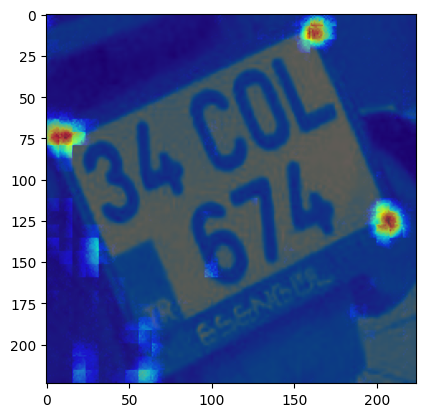

In [7]:
image = cv2.imread(path,0)
image = cv2.resize(image,(new_size[0],new_size[0])) / 255.
pred = model_load.predict(image[None])
plt.imshow(image)
#plt.imshow(pred[0][:,:,3],cmap="jet",alpha=0.5)
plt.imshow(pred[0].sum(axis=2),cmap="jet",alpha=0.6)

In [8]:
image = cv2.imread("/home/rivian/Desktop/Datasets/rec_derpet/valid/07ASP908"+".jpg",0)
image = cv2.resize(image,(new_size[0],new_size[0])) / 255.

In [10]:
pred = model_load.predict(image[None])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


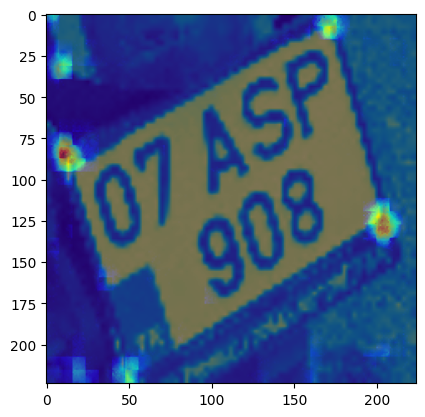

In [11]:
plt.imshow(image)
plt.imshow(pred[0].sum(axis=2),cmap="jet",alpha=0.5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


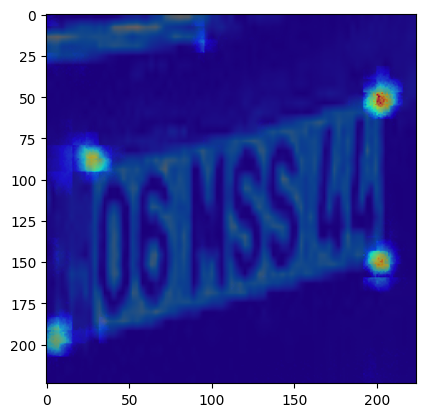

In [12]:
image = cv2.imread("/home/rivian/Desktop/Datasets/rec_derpet/test/06MSS44"+".jpg",0)
image = cv2.resize(image,(new_size[0],new_size[0])) / 255.
pred = model_load.predict(image[None])
plt.imshow(image)
#plt.imshow(pred[0][:,:,3],cmap="jet",alpha=0.5)
plt.imshow(pred[0].sum(axis=2),cmap="jet",alpha=0.6)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


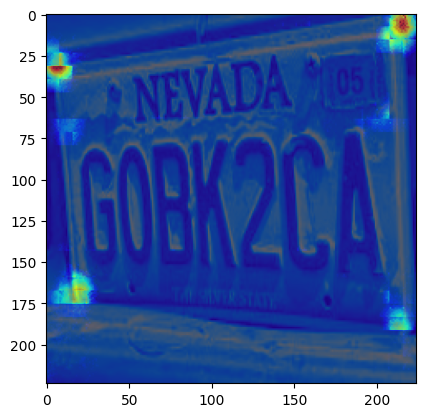

In [13]:
image = cv2.imread("/home/rivian/Desktop/Datasets/download"+".jpg",0)
image = cv2.resize(image,(new_size[0],new_size[0])) / 255.
pred = model_load.predict(image[None])
plt.imshow(image)
#plt.imshow(pred[0][:,:,3],cmap="jet",alpha=0.5)
plt.imshow(pred[0].sum(axis=2),cmap="jet",alpha=0.6)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


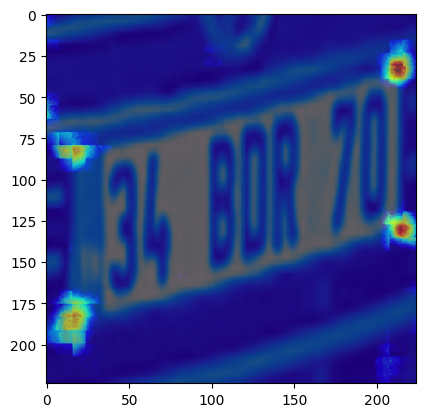

In [14]:
image = cv2.imread("/home/rivian/Desktop/Datasets/000067"+".jpg",0)
image = cv2.resize(image,(new_size[0],new_size[0])) / 255.
pred = model_load.predict(image[None])
plt.imshow(image)
#plt.imshow(pred[0][:,:,3],cmap="jet",alpha=0.5)
plt.imshow(pred[0].sum(axis=2),cmap="jet",alpha=0.6)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


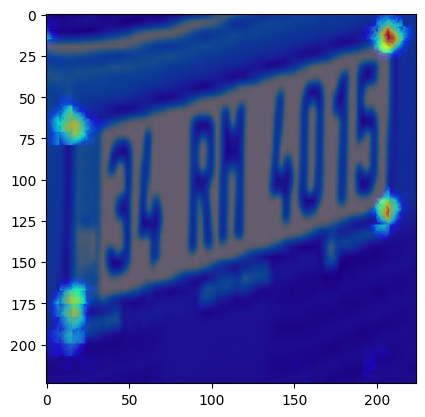

In [15]:
image = cv2.imread("/home/rivian/Desktop/Datasets/000073"+".jpg",0)
image = cv2.resize(image,(new_size[0],new_size[0])) / 255.
pred = model_load.predict(image[None])
plt.imshow(image)
#plt.imshow(pred[0][:,:,3],cmap="jet",alpha=0.5)
plt.imshow(pred[0].sum(axis=2),cmap="jet",alpha=0.6)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


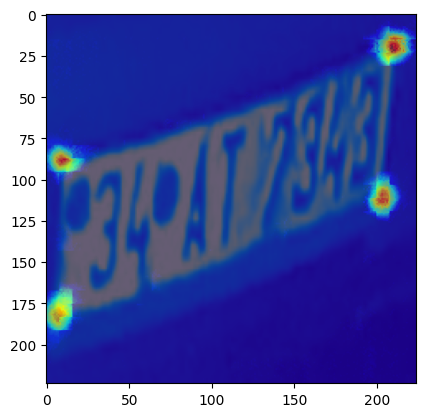

In [16]:
image = cv2.imread("/home/rivian/Desktop/Datasets/000133"+".jpg",0)
image = cv2.resize(image,(new_size[0],new_size[0])) / 255.
pred = model_load.predict(image[None])
plt.imshow(image)
#plt.imshow(pred[0][:,:,3],cmap="jet",alpha=0.5)
plt.imshow(pred[0].sum(axis=2),cmap="jet",alpha=0.6)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


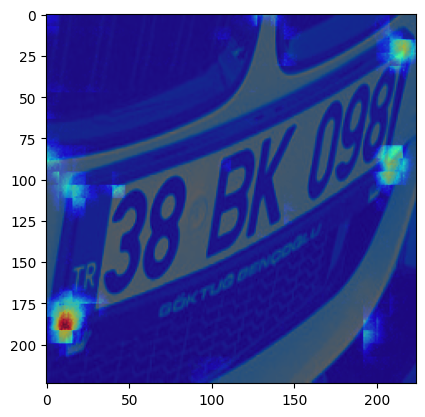

In [17]:
image = cv2.imread("/home/rivian/Desktop/Datasets/22309837"+".jpg",0)
image = cv2.resize(image,(new_size[0],new_size[0])) / 255.
pred = model_load.predict(image[None])
plt.imshow(image)
#plt.imshow(pred[0][:,:,3],cmap="jet",alpha=0.5)
plt.imshow(pred[0].sum(axis=2),cmap="jet",alpha=0.6)